In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

In [2]:
df_main = pd.read_csv('../CSV Files/main.csv')
df_train = pd.read_csv('../CSV Files/train.csv')
df_test = pd.read_csv('../CSV Files/test.csv')

# Initialize User-Item matrix

In [3]:
df_init = df_main.drop(['Stars'], axis = 1)
df_train = df_train[['Index', 'User_id', 'Product_id', 'Stars']]
df_train = pd.merge(df_init, df_train, how = 'left', on = ['Index', 'User_id', 'Product_id'])
df_train.Stars = df_train.Stars.fillna(0)

In [4]:
users_items_matrix_df = df_train.pivot_table(index = 'User_id',
                                             columns = 'Product_id',
                                             values = 'Combination',
                                             aggfunc= np.mean).fillna(0) 

users_items_matrix_df

Product_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1426.0,1427.0,1428.0,1431.0,1434.0,1435.0,1436.0,1440.0,1443.0,1452.0
User_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Auto Encoder

In [5]:
def autoEncoder(X):
    # Input, take the raw interaction matrix
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # L2 norm regularization term

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec) 
    # the output target is continus score, therefore the activation is linear
    #  regression {x-f(x)}
    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)       
    return model

In [6]:
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [7]:
model = autoEncoder(X)

model.compile(optimizer = Adam(learning_rate=0.0001), loss='mse')
    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserScore (InputLayer)      [(None, 1075)]            0         
                                                                 
 EncLayer1 (Dense)           (None, 512)               550912    
                                                                 
 LatentSpace (Dense)         (None, 256)               131328    
                                                                 
 Dropout (Dropout)           (None, 256)               0         
                                                                 
 DecLayer1 (Dense)           (None, 512)               131584    
                                                                 
 UserScorePred (Dense)       (None, 1075)              551475    
                                                                 
Total params: 1,365,299
Trainable params: 1,365,299
Non-train

In [8]:
hist = model.fit(x=X, y=y,
                 epochs=20,
                 batch_size=64,
                 shuffle=True,
                 validation_split=0.1)

Epoch 1/20


2023-04-22 14:39:46.231054: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


139/139 [==============================] - 1s 8ms/step - loss: 0.0088 - val_loss: 1.4080e-04
Epoch 2/20
139/139 [==============================] - 1s 7ms/step - loss: 0.0040 - val_loss: 9.7007e-05
Epoch 3/20
139/139 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 6.6294e-05
Epoch 4/20
139/139 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 5.1852e-05
Epoch 5/20
139/139 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 4.5150e-05
Epoch 6/20
139/139 [==============================] - 1s 8ms/step - loss: 9.5454e-04 - val_loss: 4.1279e-05
Epoch 7/20
139/139 [==============================] - 1s 8ms/step - loss: 8.1560e-04 - val_loss: 3.8462e-05
Epoch 8/20
139/139 [==============================] - 1s 8ms/step - loss: 7.2395e-04 - val_loss: 3.6599e-05
Epoch 9/20
139/139 [==============================] - 1s 9ms/step - loss: 6.6192e-04 - val_loss: 3.5398e-05
Epoch 10/20
139/139 [==============================] - 1s 9

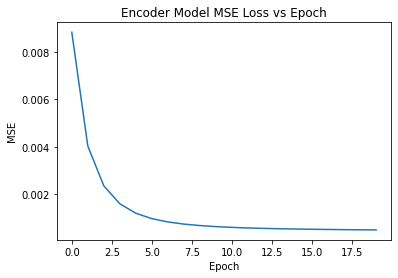

In [9]:
def plot_hist(hist):
    fig, ax = plt.subplots()  
    plt.plot(hist.history['loss'])
    plt.title('Encoder Model MSE Loss vs Epoch')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')

plot_hist(hist)

# Recommender

In [10]:
new_matrix = model.predict(X) * (X == 0)

308/308 [==============================] - 1s 2ms/step


In [11]:
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df

Product_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1426.0,1427.0,1428.0,1431.0,1434.0,1435.0,1436.0,1440.0,1443.0,1452.0
User_id,,,,,,,,,,,,,,,,,,,,,
0,-0.000097,0.000556,0.000047,0.000121,0.003215,-0.000385,0.001716,-0.000298,-0.000145,0.000768,...,0.000343,-0.000145,0.000210,-0.000203,0.000153,0.000148,-0.000052,-0.000103,0.000192,-0.000187
1,-0.000097,0.000556,0.000047,0.000121,0.003215,-0.000385,0.001716,-0.000298,-0.000145,0.000768,...,0.000343,-0.000145,0.000210,-0.000203,0.000153,0.000148,-0.000052,-0.000103,0.000192,-0.000187
2,-0.000097,0.000556,0.000047,0.000121,0.003215,-0.000385,0.001716,-0.000298,-0.000145,0.000768,...,0.000343,-0.000145,0.000210,-0.000203,0.000153,0.000148,-0.000052,-0.000103,0.000192,-0.000187
3,-0.001189,0.004247,0.002380,0.001100,0.004362,0.002590,-0.003511,0.001767,0.000123,0.003249,...,0.002872,0.001525,-0.001843,-0.001981,0.000558,-0.003257,-0.000195,0.001710,-0.000611,0.001113
4,0.001602,0.010134,0.014760,0.002409,-0.000073,-0.000977,0.008033,0.000595,0.000525,-0.011139,...,0.000207,0.002021,-0.001754,0.002033,-0.004316,-0.004105,-0.004580,-0.002071,-0.003150,0.001310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10346,-0.000097,0.000556,0.000047,0.000121,0.003215,-0.000385,0.001716,-0.000298,-0.000145,0.000768,...,0.000343,-0.000145,0.000210,-0.000203,0.000153,0.000148,-0.000052,-0.000103,0.000192,-0.000187
10347,-0.000097,0.000556,0.000047,0.000121,0.003215,-0.000385,0.001716,-0.000298,-0.000145,0.000768,...,0.000343,-0.000145,0.000210,-0.000203,0.000153,0.000148,-0.000052,-0.000103,0.000192,-0.000187
10348,-0.000097,0.000556,0.000047,0.000121,0.003215,-0.000385,0.001716,-0.000298,-0.000145,0.000768,...,0.000343,-0.000145,0.000210,-0.000203,0.000153,0.000148,-0.000052,-0.000103,0.000192,-0.000187


In [12]:
def recommender_for_user(user_id, interact_matrix, topn = 10):

    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'product_id': list(users_items_matrix_df.columns), 
                                'stars': pred_scores})
    

    df_rec      = df_scores.set_index('product_id') \
                           .sort_values('stars', ascending=False) \
                           .head(topn)[['stars']]              
    
    df_rec = df_rec[df_rec.stars > 0].reset_index()
    
    
    return df_rec['product_id'].values 

In [13]:
train_set_userids = set(df_train['User_id'].unique())
test_set_userids = set(df_test['User_id'].unique())
matching_users = train_set_userids.intersection(test_set_userids) 
user_list = pd.DataFrame(matching_users,columns=['User_id'])
user_list

,User_id
0,8193
1,2051
2,8196
3,6154
4,6155
...,...
502,8172
503,4081
504,6134
505,8182


In [14]:
User = []
Recommended = []

#create prediction

for i in user_list['User_id'].unique():
    User.append(i)
    Recommended.append(recommender_for_user(i, new_users_items_matrix_df))

In [15]:
df_eval = pd.DataFrame({'User_id': User, 'Product_ids': Recommended})
df_eval

,User_id,Product_ids
0,8193,"[40.0, 181.0, 252.0, 114.0, 87.0, 199.0, 99.0,..."
1,2051,"[298.0, 26.0, 119.0, 245.0, 258.0, 75.0, 284.0..."
2,8196,"[129.0, 301.0, 240.0, 284.0, 221.0, 248.0, 162..."
3,6154,"[90.0, 238.0, 147.0, 159.0, 240.0, 129.0, 24.0..."
4,6155,"[92.0, 267.0, 32.0, 196.0, 286.0, 77.0, 206.0,..."
...,...,...
502,8172,"[129.0, 301.0, 240.0, 284.0, 221.0, 248.0, 162..."
503,4081,"[90.0, 121.0, 115.0, 161.0, 172.0, 165.0, 167...."
504,6134,"[143.0, 95.0, 279.0, 114.0, 80.0, 57.0, 290.0,..."
505,8182,"[129.0, 301.0, 240.0, 284.0, 221.0, 248.0, 162..."


# Evaluation

In [16]:
predictions = df_eval.Product_ids

In [17]:
import math
def indicators_5(rankedList, testList):
    
    Hits_i = 0
    #Len_R = 0
    Len_T = len(testList) # maximum number of unique users
    #MRR_i = 0
    HR_i = 0
    HR_i2 = 0
    NDCG_i = 0    
    count = 0

    for i in range(len(testList)):
        for j in testList[i]:
            count = count + 1 #number of users+product combination
    
    for i in range(len(rankedList)):
        for j in range(len(rankedList[i])):
            for k in range(len(testList[i])):
                if testList[i][k]==rankedList[i][j]:
                    Hits_i+=1
                    HR_i+=1
                    HR_i2+=1
                    #MRR_i+=1/(j+1)   
                    NDCG_i+=1/(math.log2(1+j+1))
                    break
    HR_i/=Len_T #hit rate over total number of unique users
    HR_i2/=count #hit rate over total number of users+product combination
    if Hits_i == 0:
        NDCG_i = 0
    else:
        NDCG_i/=Hits_i #Dividing by Hits_i is a common way to normalize the NDCG score, and it can be useful when we don't know the ideal ranking (i.e., we don't know the IDCG). In this case, we assume that the ideal ranking contains all relevant items in the test set, and we normalize the NDCG score by the number of relevant items in the test set (i.e., Hits_i).
    print(Hits_i)
    print(f'HR_method1={HR_i}')
    print(f'HR_method2={HR_i2}')
    print(f'NDCG={NDCG_i}')

In [18]:
test_list = []
for i in test_set_userids:
    test_list.append(df_test[df_test['User_id'] == i]['Product_id'].tolist())

actual_test = pd.DataFrame(matching_users,columns=['user_id'])
actual_test['bought'] = test_list
actual_test

,user_id,bought
0,8193,[1362.0]
1,2051,[32.0]
2,8196,[1079.0]
3,6154,[233.0]
4,6155,[55.0]
...,...,...
502,8172,[1251.0]
503,4081,[73.0]
504,6134,[154.0]
505,8182,"[972.0, 1227.0]"


In [19]:
indicators_5(predictions,test_list)

1
HR_method1=0.0019723865877712033
HR_method2=0.0017152658662092624
NDCG=0.3010299956639812
